# **Book Recommender System** : Collaborative based filtering using Flask as backend framework.

Key Steps Done in This Notebook:

1) Key Steps Done in This Notebook

2) Exploratory Data Analysis (EDA)

3) Saving the Models

4) Flask Integration





- Collaborative Filtering is a technique used in recommender systems where the system recommends something to a user based on the interests/preferences of similar users.

- "Collaborative" means it depends on the collaboration (behavior, ratings, choices) of many users.

- It doesn't care about what the book is (like its title, author, genre).
It only looks at who liked what.

In [1]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gdown

**Note**:

The datasets used in this project have been loaded directly from Google Drive using their File IDs. Public access has been granted to allow seamless reading of the files. No .env configuration is required for dataset access.

In [2]:
books_file_id = '12wgnRagimRA7ew992DBTAqg54aTEGbmv'
ratings_file_id = '1x66Bvv9UmUNb8rQj7OYuX_EhaVeIsNNh'
users_file_id = '1yri5TnnUnovKG1SxUa0rhHvFYKmo69Cb'



In [3]:
# Create the downloadable URL
books_url = f'https://drive.google.com/uc?id={books_file_id}'
ratings_url = f'https://drive.google.com/uc?id={ratings_file_id}'
users_url = f'https://drive.google.com/uc?id={users_file_id}'

# Download the files
gdown.download(books_url, 'Books.csv', quiet=False)
gdown.download(ratings_url, 'Ratings.csv', quiet=False)
gdown.download(users_url, 'Users.csv', quiet=False)

# Now load the CSVs
import pandas as pd

books = pd.read_csv('Books.csv')
ratings = pd.read_csv('Ratings.csv')
users = pd.read_csv('Users.csv')


Downloading...
From: https://drive.google.com/uc?id=12wgnRagimRA7ew992DBTAqg54aTEGbmv
To: /content/Books.csv
100%|██████████| 73.3M/73.3M [00:01<00:00, 40.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1x66Bvv9UmUNb8rQj7OYuX_EhaVeIsNNh
To: /content/Ratings.csv
100%|██████████| 22.6M/22.6M [00:00<00:00, 91.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yri5TnnUnovKG1SxUa0rhHvFYKmo69Cb
To: /content/Users.csv
100%|██████████| 11.0M/11.0M [00:00<00:00, 119MB/s]
<ipython-input-3-e25453faf872>:14: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('Books.csv')


In [4]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [7]:
print(books.shape)
print(ratings.shape)
print(users.shape)

(271360, 8)
(1149780, 3)
(278858, 3)


##Checking for Missing values

In [8]:

books.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,2
Year-Of-Publication,0
Publisher,2
Image-URL-S,0
Image-URL-M,0
Image-URL-L,3


In [9]:
users.isnull().sum()

,0
User-ID,0
Location,0
Age,110762


Many missing values present in Age column of users dataset, but for now we won't be needing the age column.

In [10]:
ratings.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0


##Checking for duplicates

In [11]:
#checking for duplicates
books.duplicated().sum()

np.int64(0)

In [12]:
ratings.duplicated().sum()

np.int64(0)

In [13]:
users.duplicated().sum()

np.int64(0)

No duplicated values present in any of the dataframes.


#Popularity based Recommender System

Displaying top 50 books with highest average rating, will be considering only those books which has minimum 250 votes.


In [14]:
ratings.head(2)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5


In [15]:
books.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [16]:
ratings_with_name = ratings.merge(books, on="ISBN")

In [17]:
ratings_with_name.shape

(1031136, 10)

In [18]:
num_rating_df = ratings_with_name.groupby('Book-Title').count()['Book-Rating'].reset_index()
num_rating_df.rename(columns={'Book-Rating':'num_ratings'}, inplace=True)
num_rating_df

,Book-Title,num_ratings
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1
...,...,...
241066,Ã?Â?lpiraten.,2
241067,Ã?Â?rger mit Produkt X. Roman.,4
241068,Ã?Â?sterlich leben.,1
241069,Ã?Â?stlich der Berge.,3


In [19]:
avg_rating_df = ratings_with_name.groupby('Book-Title').mean(numeric_only=True)['Book-Rating'].reset_index()
avg_rating_df.rename(columns={'Book-Rating':'avg_ratings'}, inplace=True)
avg_rating_df

,Book-Title,avg_ratings
0,A Light in the Storm: The Civil War Diary of ...,2.250000
1,Always Have Popsicles,0.000000
2,Apple Magic (The Collector's series),0.000000
3,"Ask Lily (Young Women of Faith: Lily Series, ...",8.000000
4,Beyond IBM: Leadership Marketing and Finance ...,0.000000
...,...,...
241066,Ã?Â?lpiraten.,0.000000
241067,Ã?Â?rger mit Produkt X. Roman.,5.250000
241068,Ã?Â?sterlich leben.,7.000000
241069,Ã?Â?stlich der Berge.,2.666667


In [20]:
avg_rating_df['avg_ratings'] = avg_rating_df['avg_ratings'].round(2)

In [21]:
#merging the num_rating_df and avg_rating_df
popular_df = num_rating_df.merge(avg_rating_df, on="Book-Title")
popular_df

,Book-Title,num_ratings,avg_ratings
0,A Light in the Storm: The Civil War Diary of ...,4,2.25
1,Always Have Popsicles,1,0.00
2,Apple Magic (The Collector's series),1,0.00
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1,8.00
4,Beyond IBM: Leadership Marketing and Finance ...,1,0.00
...,...,...,...
241066,Ã?Â?lpiraten.,2,0.00
241067,Ã?Â?rger mit Produkt X. Roman.,4,5.25
241068,Ã?Â?sterlich leben.,1,7.00
241069,Ã?Â?stlich der Berge.,3,2.67


In [22]:
popular_df = popular_df[popular_df["num_ratings"]>=250].sort_values('avg_ratings', ascending=False).head(50)

In [23]:
popular_df

,Book-Title,num_ratings,avg_ratings
80434,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.85
80422,Harry Potter and the Goblet of Fire (Book 4),387,5.82
80441,Harry Potter and the Sorcerer's Stone (Book 1),278,5.74
80426,Harry Potter and the Order of the Phoenix (Boo...,347,5.50
80414,Harry Potter and the Chamber of Secrets (Book 2),556,5.18
191612,The Hobbit : The Enchanting Prelude to The Lor...,281,5.01
187377,The Fellowship of the Ring (The Lord of the Ri...,368,4.95
80445,Harry Potter and the Sorcerer's Stone (Harry P...,575,4.90
211384,"The Two Towers (The Lord of the Rings, Part 2)",260,4.88
219741,To Kill a Mockingbird,510,4.70


In [24]:
popular_df.merge(books, on='Book-Title').drop_duplicates('Book-Title').shape

(50, 10)

In [25]:
popular_df = popular_df.merge(books, on='Book-Title').drop_duplicates('Book-Title')[['Book-Title','Book-Author','Image-URL-M', 'num_ratings','avg_ratings']]

In [26]:
popular_df

,Book-Title,Book-Author,Image-URL-M,num_ratings,avg_ratings
0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,http://images.amazon.com/images/P/0439136350.0...,428,5.85
3,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,http://images.amazon.com/images/P/0439139597.0...,387,5.82
5,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,http://images.amazon.com/images/P/0590353403.0...,278,5.74
9,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,http://images.amazon.com/images/P/043935806X.0...,347,5.50
13,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,http://images.amazon.com/images/P/0439064872.0...,556,5.18
16,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339681.0...,281,5.01
17,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339703.0...,368,4.95
26,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,http://images.amazon.com/images/P/059035342X.0...,575,4.90
28,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339711.0...,260,4.88
39,To Kill a Mockingbird,Harper Lee,http://images.amazon.com/images/P/0446310786.0...,510,4.70


Top 10 Most Popular Authors:
Book-Author
J. K. Rowling         6
J.R.R. TOLKIEN        3
Barbara Kingsolver    2
Neil Gaiman           2
Janet Evanovich       2
J.D. Salinger         1
Harper Lee            1
Dan Brown             1
George Orwell         1
Alice Sebold          1
Name: count, dtype: int64


<ipython-input-27-c35c8df86a15>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.values, y=top_authors.index, palette='magma')


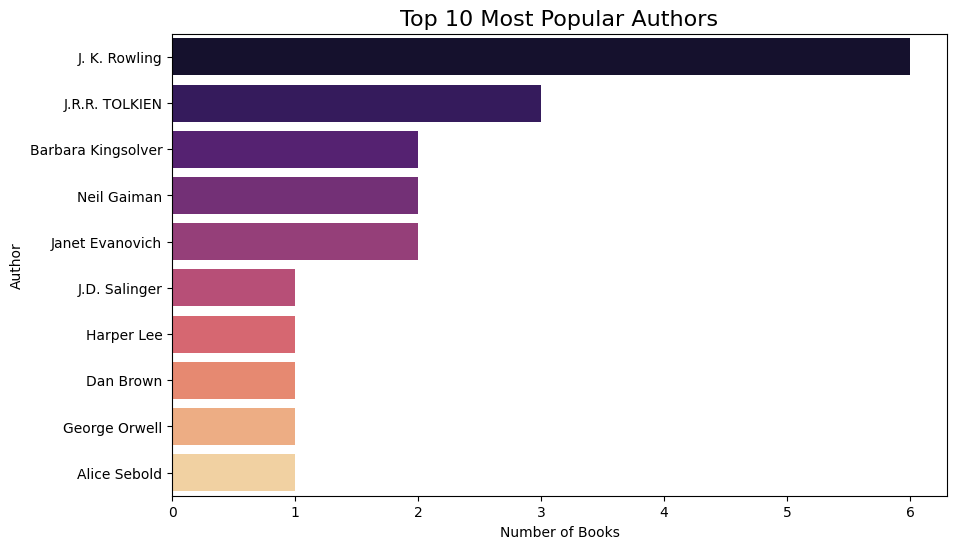

In [27]:
# Finding most popular authors
top_authors = popular_df['Book-Author'].value_counts().head(10)

# Display
print("Top 10 Most Popular Authors:")
print(top_authors)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=top_authors.values, y=top_authors.index, palette='magma')
plt.title('Top 10 Most Popular Authors', fontsize=16)
plt.xlabel('Number of Books')
plt.ylabel('Author')
plt.show()


In [28]:
# Checking for duplicate book titles
duplicate_titles = popular_df['Book-Title'].duplicated().sum()
print(f"Number of duplicate book titles: {duplicate_titles}")


Number of duplicate book titles: 0


#Collaborative Based Filtering

We will be taking only those users who have given atleast 200 book ratings

In [29]:
ratings_with_name

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
...,...,...,...,...,...,...,...,...,...,...
1031131,276704,0876044011,0,Edgar Cayce on the Akashic Records: The Book o...,Kevin J. Todeschi,1998,A.R.E. Press (Association of Research &amp; Enlig,http://images.amazon.com/images/P/0876044011.0...,http://images.amazon.com/images/P/0876044011.0...,http://images.amazon.com/images/P/0876044011.0...
1031132,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press,http://images.amazon.com/images/P/1563526298.0...,http://images.amazon.com/images/P/1563526298.0...,http://images.amazon.com/images/P/1563526298.0...
1031133,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997,Alfred A. Knopf,http://images.amazon.com/images/P/0679447156.0...,http://images.amazon.com/images/P/0679447156.0...,http://images.amazon.com/images/P/0679447156.0...
1031134,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books,http://images.amazon.com/images/P/0515107662.0...,http://images.amazon.com/images/P/0515107662.0...,http://images.amazon.com/images/P/0515107662.0...


In [30]:
x = ratings_with_name.groupby('User-ID').count()['Book-Rating'] > 200
considered_users = x[x].index

In [31]:
filtered_rating = ratings_with_name[ratings_with_name['User-ID'].isin(considered_users)]

We will be taking only the top 50 books

In [32]:
y = filtered_rating.groupby('Book-Title').count()['Book-Rating']>=50
famous_books = y[y].index

In [33]:
final_ratings = filtered_rating[filtered_rating['Book-Title'].isin(famous_books)]

In [34]:
final_ratings

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1150,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...
1163,277427,0060930535,0,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...
1165,277427,0060934417,0,Bel Canto: A Novel,Ann Patchett,2002,Perennial,http://images.amazon.com/images/P/0060934417.0...,http://images.amazon.com/images/P/0060934417.0...,http://images.amazon.com/images/P/0060934417.0...
1168,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,1995,HarperTorch,http://images.amazon.com/images/P/0061009059.0...,http://images.amazon.com/images/P/0061009059.0...,http://images.amazon.com/images/P/0061009059.0...
1174,277427,006440188X,0,The Secret Garden,Frances Hodgson Burnett,1998,HarperTrophy,http://images.amazon.com/images/P/006440188X.0...,http://images.amazon.com/images/P/006440188X.0...,http://images.amazon.com/images/P/006440188X.0...
...,...,...,...,...,...,...,...,...,...,...
1029196,275970,1400031354,0,Tears of the Giraffe (No.1 Ladies Detective Ag...,Alexander McCall Smith,2002,Anchor,http://images.amazon.com/images/P/1400031354.0...,http://images.amazon.com/images/P/1400031354.0...,http://images.amazon.com/images/P/1400031354.0...
1029197,275970,1400031362,0,Morality for Beautiful Girls (No.1 Ladies Dete...,Alexander McCall Smith,2002,Anchor,http://images.amazon.com/images/P/1400031362.0...,http://images.amazon.com/images/P/1400031362.0...,http://images.amazon.com/images/P/1400031362.0...
1029270,275970,1573229725,0,Fingersmith,Sarah Waters,2002,Riverhead Books,http://images.amazon.com/images/P/1573229725.0...,http://images.amazon.com/images/P/1573229725.0...,http://images.amazon.com/images/P/1573229725.0...
1029309,275970,1586210661,9,Me Talk Pretty One Day,David Sedaris,2001,Time Warner Audio Major,http://images.amazon.com/images/P/1586210661.0...,http://images.amazon.com/images/P/1586210661.0...,http://images.amazon.com/images/P/1586210661.0...


In [35]:
pivot_table = final_ratings.pivot_table(index='Book-Title', columns='User-ID', values='Book-Rating')

In [36]:
pivot_table

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bend in the Road,0.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,9.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
You Belong To Me,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [37]:
#Filling NaN values with 0
pivot_table.fillna(0, inplace=True)

In [38]:
pivot_table

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For calculating distance, we would be considering each book as a vector in 810 dimensional space and we will calculating the euclidean distance between the vectors to find similiar books.

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

In [40]:
similarity_score = cosine_similarity(pivot_table)

In [41]:
similarity_score.shape

(706, 706)

In [42]:
def recommend(book_name):
  #index fetch
  index = np.where(pivot_table.index == book_name)[0][0]
  similar_items = sorted(list(enumerate(similarity_score[index])), key = lambda x:x[1], reverse=True)[1:11]

  data = []
  for i in similar_items:
    item = []
    temp_df = books[books['Book-Title'] == pivot_table.index[i[0]]]

    item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
    item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
    item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))

    data.append(item)

  return data

In [ ]:
# sorted(list(enumerate(similarity_score[0])), key = lambda x:x[1], reverse=True)[1:6]
# #sorting out and bringing out top 5 books(with highest similarity score) that are most similar to the book the user chooses.

[(47, np.float64(0.2702651417103732)),
 (545, np.float64(0.2639619371123496)),
 (82, np.float64(0.2366937434740099)),
 (634, np.float64(0.23299389358170397)),
 (551, np.float64(0.2262639743141286))]

In [43]:
recommend('1984')

[['Animal Farm',
  'George Orwell',
  'http://images.amazon.com/images/P/0451526341.01.MZZZZZZZ.jpg'],
 ["The Handmaid's Tale",
  'Margaret Atwood',
  'http://images.amazon.com/images/P/0449212602.01.MZZZZZZZ.jpg'],
 ['Brave New World',
  'Aldous Huxley',
  'http://images.amazon.com/images/P/0060809833.01.MZZZZZZZ.jpg'],
 ['The Vampire Lestat (Vampire Chronicles, Book II)',
  'ANNE RICE',
  'http://images.amazon.com/images/P/0345313860.01.MZZZZZZZ.jpg'],
 ['The Hours : A Novel',
  'Michael Cunningham',
  'http://images.amazon.com/images/P/0312243022.01.MZZZZZZZ.jpg'],
 ['Fahrenheit 451',
  'Ray Bradbury',
  'http://images.amazon.com/images/P/3257208626.01.MZZZZZZZ.jpg'],
 ['The Catcher in the Rye',
  'J.D. Salinger',
  'http://images.amazon.com/images/P/0316769487.01.MZZZZZZZ.jpg'],
 ['Naked',
  'David Sedaris',
  'http://images.amazon.com/images/P/0316777730.01.MZZZZZZZ.jpg'],
 ['The Hundred Secret Senses',
  'Amy Tan',
  'http://images.amazon.com/images/P/0399141146.01.MZZZZZZZ.jpg']

In [44]:
import pickle

pickle.dump(popular_df, open('popular.pkl','wb'))

In [45]:
pickle.dump(pivot_table, open('pivot_table.pkl','wb'))
pickle.dump(books, open('books.pkl','wb'))
pickle.dump(similarity_score, open('similarity_score.pkl','wb'))